In [1]:
!python --version

Python 3.7.7


In [2]:
#https://stackoverflow.com/questions/53457975/pyspark-udf-function-error-in-lambda-function
import os
os.environ['OBJC_DISABLE_INITIALIZE_FORK_SAFETY'] = 'YES'

In [3]:
from pyspark.sql import SparkSession
# https://spark.apache.org/docs/latest/job-scheduling.html
spark = SparkSession.\
        builder.\
        appName("pyspark-notebook2-ais").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "7g").\
        config("spark.cores.max", "3").\
        config("spark.executor.instances", "1").\
        config("spark.executor.cores", "3").\
        config("spark.mongodb.input.uri","mongodb://mongo1:27017,mongo2:27018,mongo3:27019/database.horses_collection?replicaSet=rs0").\
        config("spark.mongodb.output.uri","mongodb://mongo1:27017,mongo2:27018,mongo3:27019/database.horses_collection?replicaSet=rs0").\
        config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.0").\
        getOrCreate()


Ivy Default Cache set to: /home/jovyan/.ivy2/cache
The jars for the packages stored in: /home/jovyan/.ivy2/jars
:: loading settings :: url = jar:file:/usr/local/spark-3.0.0-bin-hadoop3.2/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-2c670492-8dd5-4cb4-b691-e32c247f7021;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.12;3.0.0 in central
	found org.mongodb#mongodb-driver-sync;4.0.5 in central
	found org.mongodb#bson;4.0.5 in central
	found org.mongodb#mongodb-driver-core;4.0.5 in central
:: resolution report :: resolve 330ms :: artifacts dl 12ms
	:: modules in use:
	org.mongodb#bson;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-core;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-sync;4.0.5 from central in [default]
	org.mongodb.spark#mongo-spark-connector_2.12;3.0.0 from central in [defaul

In [4]:
spark.catalog.currentDatabase()

'default'

In [5]:
#reading dataframes from MongoDB

# sampleSize - https://stackoverflow.com/a/56255303
df = spark.read.format("mongo").option('sampleSize', 50000).load()
df.createOrReplaceTempView("mongo")


21/12/22 18:48:57 WARN MongoInferSchema: Field 'bsp' contains conflicting types converting to StringType
21/12/22 18:48:59 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [6]:
df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- clk: string (nullable = true)
 |-- mc: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: string (nullable = true)
 |    |    |-- marketDefinition: struct (nullable = true)
 |    |    |    |-- betDelay: integer (nullable = true)
 |    |    |    |-- bettingType: string (nullable = true)
 |    |    |    |-- bspMarket: boolean (nullable = true)
 |    |    |    |-- bspReconciled: boolean (nullable = true)
 |    |    |    |-- complete: boolean (nullable = true)
 |    |    |    |-- countryCode: string (nullable = true)
 |    |    |    |-- crossMatching: boolean (nullable = true)
 |    |    |    |-- discountAllowed: boolean (nullable = true)
 |    |    |    |-- eachWayDivisor: double (nullable = true)
 |    |    |    |-- eventId: string (nullable = true)
 |    |    |    |-- eventName: string (nullable = true)
 |    |    |    |-- eventTypeId: string (nullable = true)
 | 

In [7]:
#df.show()

In [8]:
#spark.sql("select * from mongo array_contains(root.mc, array('CLOSED'))").show()
from pyspark.sql.functions import explode   # Explodes lists into rows.

In [9]:
mc_exploded = df.select('*', explode(df.mc).alias('mc_row'))

In [10]:
md_only = mc_exploded.filter(mc_exploded.mc_row.marketDefinition.isNotNull())

In [11]:
#md_only.show()

In [12]:
# Explode the marketDefinition array.
market_definitions = md_only.selectExpr('op AS operation_type',
                                        'clk AS sequence_token',
                                        'pt AS published_time',
                                        'mc_row.id AS market_id',
                                        'mc_row.rc AS rc',
                                        'mc_row.marketDefinition.betDelay AS bet_delay',
                                        'mc_row.marketDefinition.bettingType AS betting_type',
                                        'mc_row.marketDefinition.bspMarket AS bsp_market',
                                        'mc_row.marketDefinition.bspReconciled AS bsp_reconciled',
                                        'mc_row.marketDefinition.complete AS complete',
                                        'mc_row.marketDefinition.countryCode AS country_code',
                                        'mc_row.marketDefinition.crossMatching AS cross_matching',
                                        'mc_row.marketDefinition.discountAllowed AS discount_allowed',
                                        'mc_row.marketDefinition.eventId AS event_id',
                                        'mc_row.marketDefinition.eventName AS event_name',
                                        'mc_row.marketDefinition.eventTypeId AS event_type_id',
                                        'mc_row.marketDefinition.inPlay AS in_play',
                                        'mc_row.marketDefinition.marketBaseRate AS market_base_rate',
                                        'mc_row.marketDefinition.marketTime AS market_time',
                                        'mc_row.marketDefinition.marketType AS market_type',
                                        'mc_row.marketDefinition.numberOfActiveRunners AS number_of_active_runners',
                                        'mc_row.marketDefinition.numberOfWinners AS number_of_winners',
                                        'mc_row.marketDefinition.openDate AS open_date',
                                        'mc_row.marketDefinition.persistenceEnabled AS persistence_enabled',
                                        'mc_row.marketDefinition.runnersVoidable AS runners_voidable',
                                        'mc_row.marketDefinition.settledTime AS settled_time',
                                        'mc_row.marketDefinition.status AS status',
                                        'mc_row.marketDefinition.suspendTime AS suspend_time',
                                        'mc_row.marketDefinition.timezone AS timezone',
                                        'mc_row.marketDefinition.turnInPlayEnabled AS turn_in_play_enabled',
                                        'mc_row.marketDefinition.version AS version',
                                        'mc_row.marketDefinition.name AS market_name',
                                        'mc_row.marketDefinition.regulators AS regulators',
                                        'mc_row.marketDefinition.runners AS runners')

In [13]:
market_definitions = market_definitions.filter(market_definitions["status"]=="CLOSED")

In [14]:
market_definitions = market_definitions.filter(market_definitions["market_type"]=="WIN")

In [15]:
runners_only = market_definitions.filter(market_definitions.runners.isNotNull())

In [16]:
runners_exploded_wbsp = runners_only.select(market_definitions.operation_type,
                                       market_definitions.published_time,
                                       market_definitions.market_id,
                                       market_definitions.market_name,
                                       market_definitions.event_id,
                                       market_definitions.event_name,
                                       market_definitions.number_of_active_runners,
                                       explode(market_definitions.runners).alias('runner_row'))

In [17]:
runners_wbsp = runners_exploded_wbsp.selectExpr('operation_type',
                                      'published_time',
                                      'market_id',
                                      'market_name',
                                      'event_id',
                                      'event_name',
                                      'number_of_active_runners',
                                      'runner_row.id AS runner_id',
                                      'runner_row.name AS runner_name',
                                      'runner_row.status AS runner_status',
                                      'runner_row.bsp AS bsp',
                                      'runner_row.sortPriority AS runner_sort_priority')

In [18]:
runners_wbsp = runners_wbsp.filter(runners_wbsp.runner_status!='REMOVED')

In [19]:
runners_wbsp = runners_wbsp.filter(runners_wbsp.runner_status!='REMOVED_VACANT')

In [20]:
#runners_wbsp.count()

In [21]:
runners_wbsp = runners_wbsp.dropDuplicates()

In [22]:
#runners_wbsp.count()

In [23]:
#runners_wbsp.describe().show()

In [24]:
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType

In [25]:
#bsps are integers

runners_wbsp = runners_wbsp.withColumn("bsp", runners_wbsp["bsp"].cast(IntegerType()))

In [26]:
#bsps must be >1 as they are decimal odds, which must always have a value greater than 1 (see https://www.timeform.com/betting/basics/understanding-decimal-odds)

runners_wbsp = runners_wbsp.filter(runners_wbsp.bsp>1)

# Starting Prices
## How often does the best-ranked horse (as determined by BSP) win? Is it better than random chance?

Ranking the horses in each race based on Betfair Starting Prices (BSP) (lowest BSP is best [rank=1], highest BSP is worst). This is done so we can see how often Betfair's ranking is correct

In [27]:
runners_wbsp_rank=runners_wbsp.withColumn(
  "rank", dense_rank().over(Window.partitionBy("market_id").orderBy(asc("bsp"))))

Reverse Ranking and limiting to where reverse_rank = 1 (rank is therefore the highest count observation within race). This will allow us to find the average number of runners per race. Random chance would predict the winner in 1/(avg. number of runners)% of races. Does Betfair's prices do better than that?

In [28]:
runners_wbsp_rank=runners_wbsp_rank.withColumn(
  "reverse_rank", dense_rank().over(Window.partitionBy("market_id").orderBy(desc("bsp"))))

In [29]:
runners_wbsp_reverserank = runners_wbsp_rank.filter(col("reverse_rank") == 1)

We see from the rank summary below that the mean is 7.907. This is the average number of runners in a race.

In [32]:
runners_wbsp_reverserank.describe().show()

+-------+--------------+--------------------+--------------------+--------------+-------------------+-------------------+------------------------+-----------------+-----------+-------------+------------------+--------------------+-----------------+------------+
|summary|operation_type|      published_time|           market_id|   market_name|           event_id|         event_name|number_of_active_runners|        runner_id|runner_name|runner_status|               bsp|runner_sort_priority|             rank|reverse_rank|
+-------+--------------+--------------------+--------------------+--------------+-------------------+-------------------+------------------------+-----------------+-----------+-------------+------------------+--------------------+-----------------+------------+
|  count|         52533|               52533|               52533|         52533|              52533|              52533|                   52533|            52533|      52533|        52533|             52533|     

Grouping by runner_status (whether the horse was a winner of loser) and rank to get the distribution of winners and losers by rank

In [30]:
runners_wbsp_rank.groupby("runner_status", "rank").count().show(10)

+-------------+----+-----+
|runner_status|rank|count|
+-------------+----+-----+
|       WINNER|   8|  631|
|        LOSER|  20|   87|
|        LOSER|  31|    1|
|       WINNER|  12|   69|
|       WINNER|   2|10187|
|        LOSER|  25|   14|
|        LOSER|   2|48991|
|        LOSER|  27|    4|
|        LOSER|   4|49656|
|        LOSER|  28|    4|
+-------------+----+-----+
only showing top 10 rows



In [31]:
runners_wbsp_rank1 = runners_wbsp_rank.groupby("runner_status", "rank").count()

In [92]:
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [30, 15]

In [33]:
############################################################
pdf_1 = runners_wbsp_rank1.toPandas()
############################################################

<AxesSubplot:title={'center':'Racehorse Distribution by Rank and Outcome'}, xlabel='rank', ylabel='horses'>

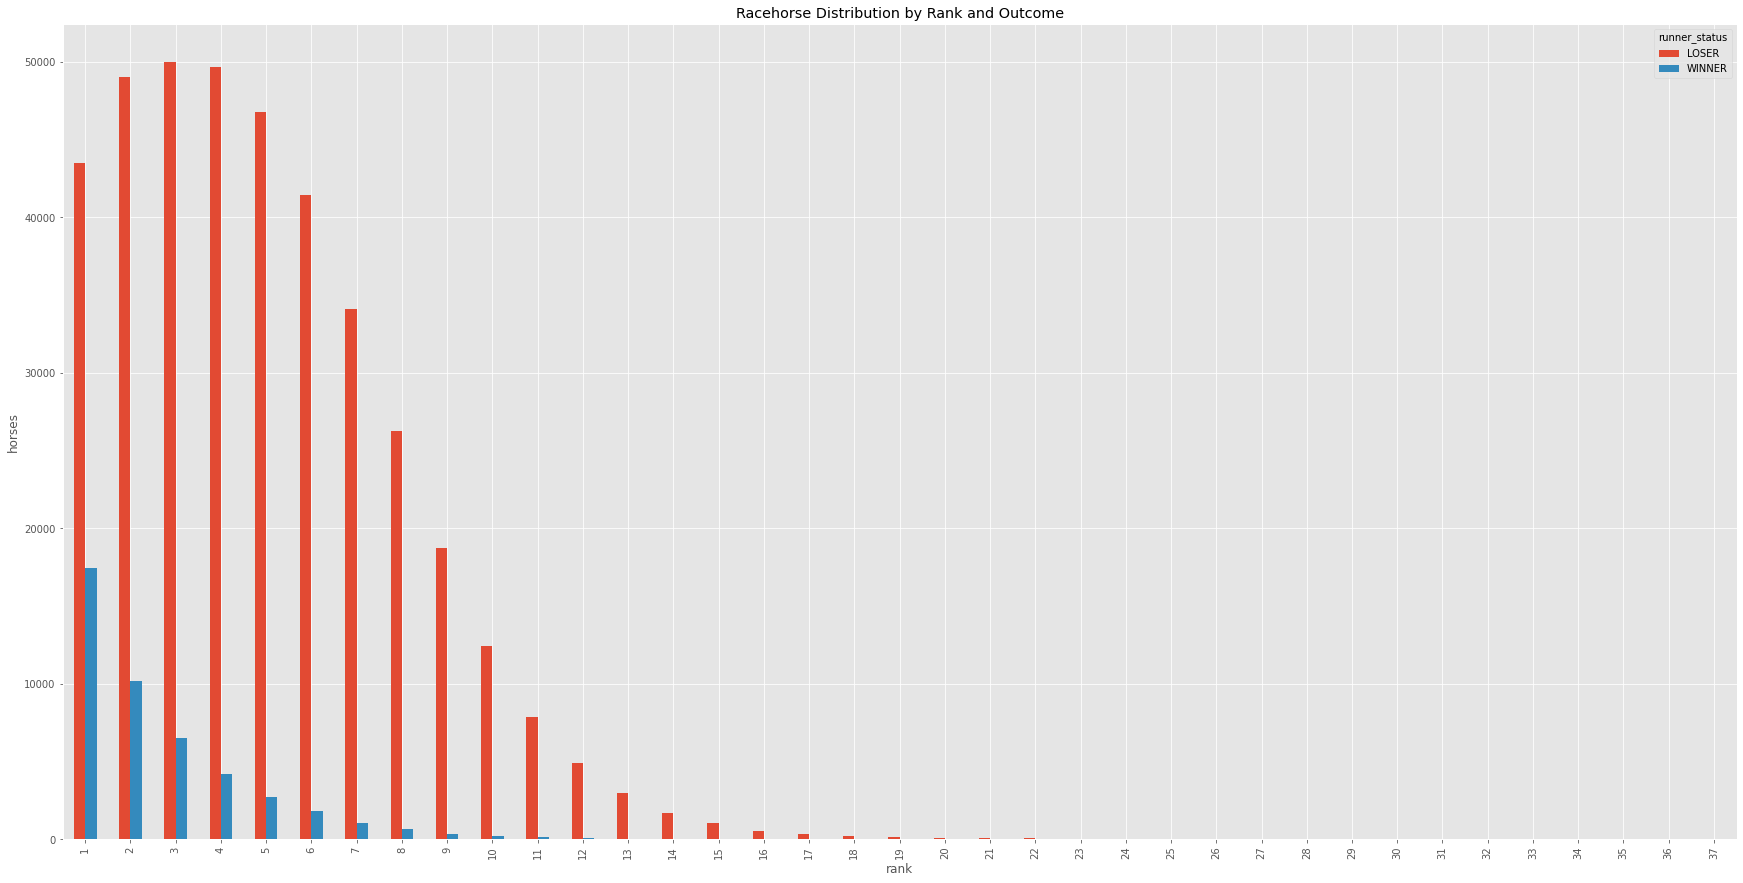

In [93]:
plt.style.use('ggplot')
pdf_1.pivot('rank', 'runner_status', 'count').plot(kind = 'bar', stacked=False, ylabel = 'horses',  title = 'Racehorse Distribution by Rank and Outcome')

In [34]:
# sum of all winners and losers

pdf_1.groupby(["runner_status"]).agg({"count" : "sum"})

,count
runner_status,
LOSER,391567
WINNER,45234


In [36]:
# as a percentage

pdf_1.groupby(["runner_status"])\
.agg({"count" : "sum"})[["count"]]\
.apply(lambda x: 100*x/x.sum())\
.sort_values(by="count", ascending=False)

,count
runner_status,
LOSER,89.644254
WINNER,10.355746


<AxesSubplot:title={'center':'Racehorse Outcome'}, xlabel='runner_status', ylabel='Horses'>

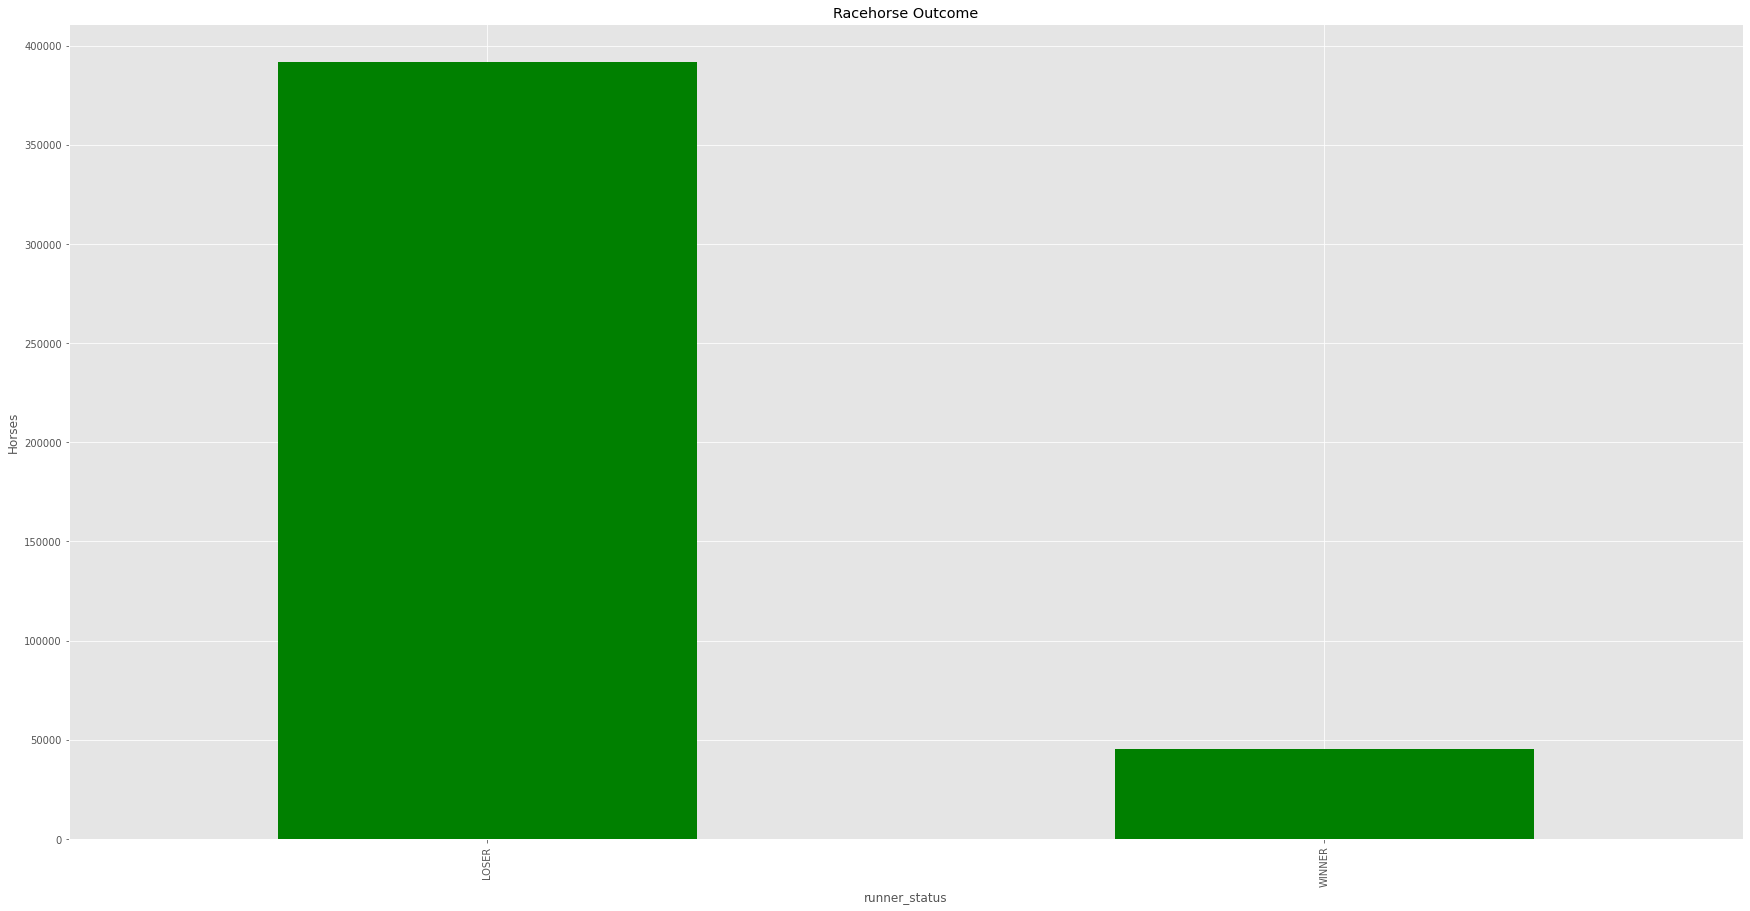

In [94]:
# plotted

pdf_1.groupby(["runner_status"]).agg({"count" : "sum"}).plot(kind = 'bar', stacked=False, ylabel = 'Horses', legend=False, color = 'g', title = 'Racehorse Outcome')

In [37]:
# looking at winners only in order to get % distribution by rank

pdf_winners = pdf_1.loc[pdf_1['runner_status'] == "WINNER"]

In [38]:
winner_percentages = pdf_winners.groupby(["rank"])\
.agg({"count" : "sum"})[["count"]]\
.apply(lambda x: 100*x/x.sum())\
.sort_values(by="rank", ascending=True)

winner_percentages

,count
rank,
1,38.566123
2,22.520670
3,14.303400
4,9.313791
5,5.980015
6,3.917407
7,2.343370
8,1.394968
9,0.716275


<AxesSubplot:title={'center':'Winners: Percentage Distribution by Rank'}, xlabel='rank', ylabel='Percentage of Winners'>

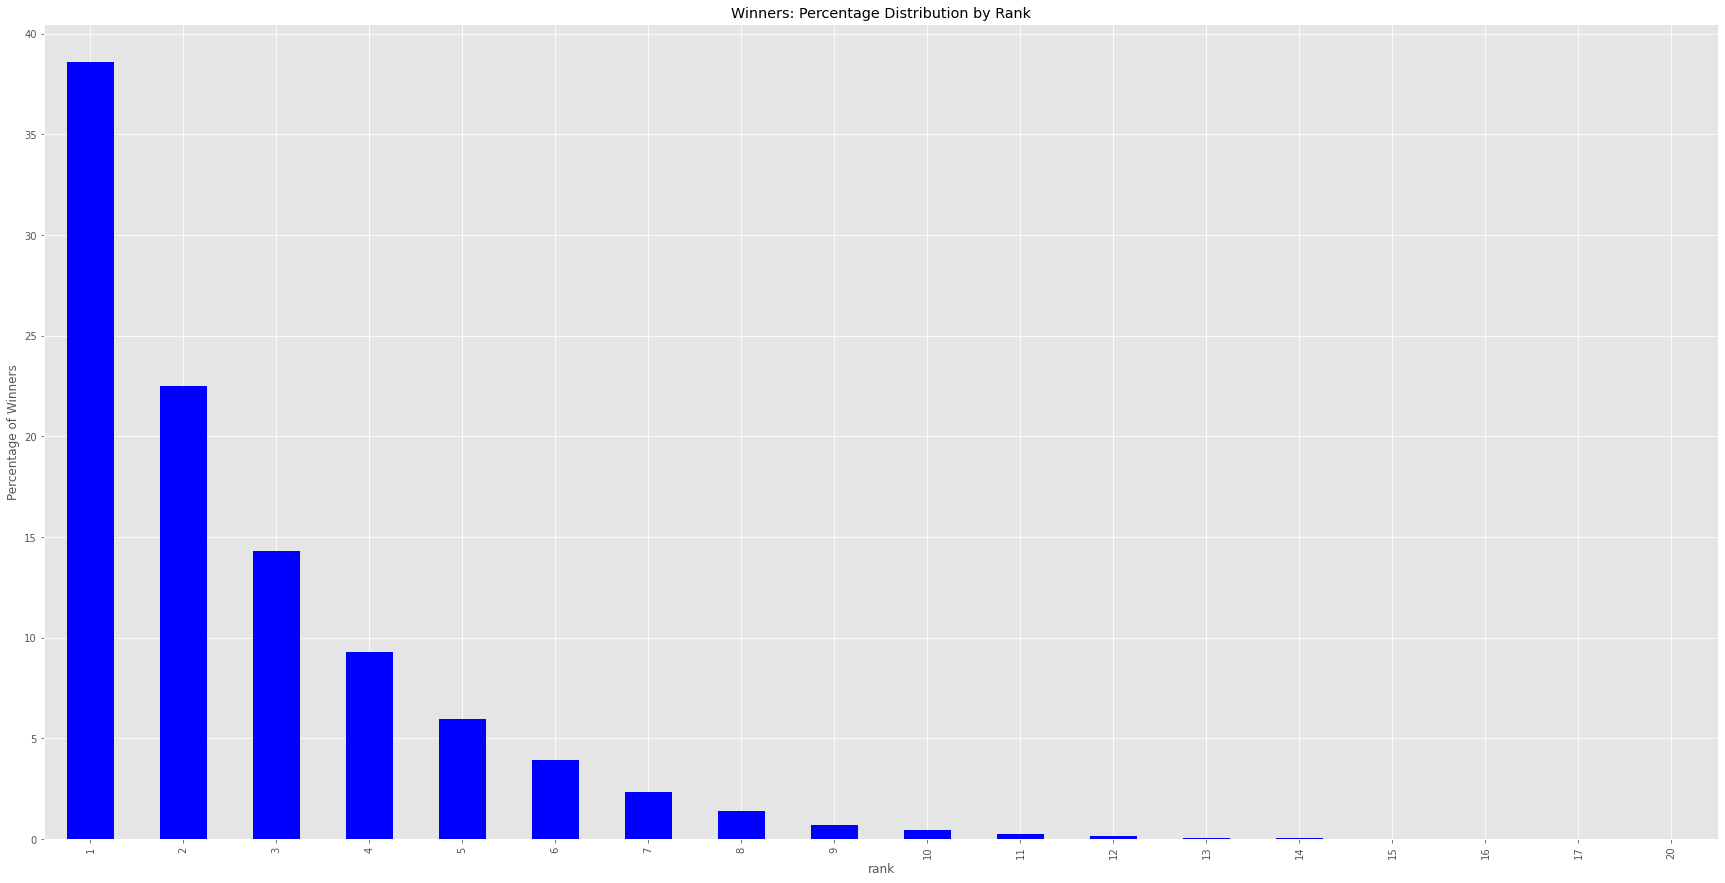

In [95]:
winner_percentages.plot(kind = 'bar', stacked=False, ylabel = 'Percentage of Winners', color = 'b', legend=False, title = 'Winners: Percentage Distribution by Rank')

In [40]:
# looking at winners only in order to get % distribution by rank

pdf_losers = pdf_1.loc[pdf_1['runner_status'] == "LOSER"]

In [41]:
loser_percentages = pdf_losers.groupby(["rank"])\
.agg({"count" : "sum"})[["count"]]\
.apply(lambda x: 100*x/x.sum())\
.sort_values(by="rank", ascending=True)

<AxesSubplot:title={'center':'Losers: Percentage Distribution by Rank'}, xlabel='rank', ylabel='Percentage of Losers'>

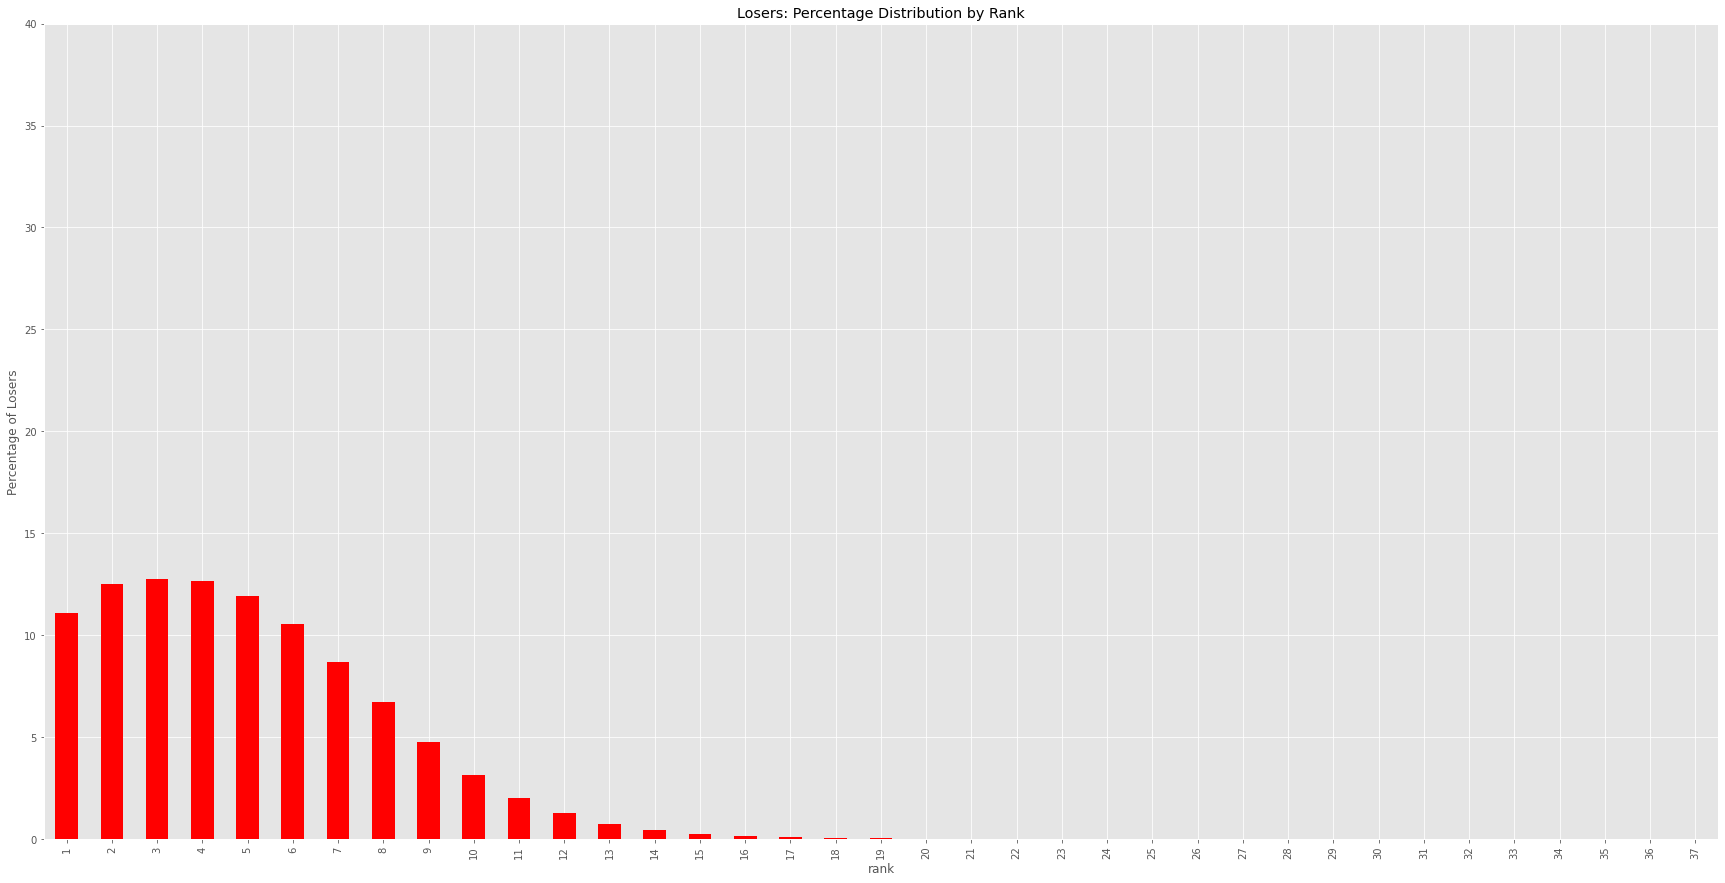

In [96]:
loser_percentages.plot(kind = 'bar', stacked=False, ylabel = 'Percentage of Losers', legend=False, title = 'Losers: Percentage Distribution by Rank',  color='r', ylim =(0, 40))

# Price movements

In [43]:
runners_wbsp_GoldCup = runners_wbsp.filter(runners_wbsp.event_id=='27653664')

In [44]:
runners_wbsp_GoldCup = runners_wbsp.filter(runners_wbsp.market_name=='2m6f Hcap Chs')

In [45]:
runners_wbsp_GoldCup.show()

+--------------+--------------+-----------+-------------+--------+--------------+------------------------+---------+------------------+-------------+---+--------------------+
|operation_type|published_time|  market_id|  market_name|event_id|    event_name|number_of_active_runners|runner_id|       runner_name|runner_status|bsp|runner_sort_priority|
+--------------+--------------+-----------+-------------+--------+--------------+------------------------+---------+------------------+-------------+---+--------------------+
|           mcm| 1452785180209|1.122576498|2m6f Hcap Chs|27653664|Thurl 14th Jan|                       0|  7011147|          He Rocks|        LOSER|  8|                   4|
|           mcm| 1479563081187|1.128344068|2m6f Hcap Chs|28022833|Punch 19th Nov|                       0|  7843173|    Art Of Payroll|        LOSER| 32|                  10|
|           mcm| 1480167761078|1.128448836|2m6f Hcap Chs|28029484| Newb 26th Nov|                       0|  7253667|        F

In [46]:


# Filter down to only the records that have rc (runner changes).
rc_only = mc_exploded.filter(mc_exploded.mc_row.rc.isNotNull())

# Explode the rc (runner changes) array.
rc_exploded = rc_only.select(rc_only.op.alias('operation_type'),
                             rc_only.pt.alias('published_time'),
                             rc_only.mc_row.id.alias('market_id'),
                             explode(rc_only.mc_row.rc).alias('runner_change_row'))

rc_exploded = rc_exploded.filter(rc_exploded.market_id=='1.122576498')

# Select the useful fields, and give them user friendly names.
runner_changes = rc_exploded.selectExpr('operation_type',
                                        'published_time',
                                        'market_id',
                                        'runner_change_row.id AS runner_id',
                                        'runner_change_row.ltp AS last_traded_price')



In [47]:
# This market_id is for the a Thurles race in Jan 2016
selection_condition = "market_id = '1.122576498'"

chosen_runners = runners_wbsp.filter(selection_condition).selectExpr('market_id', 
                                                                'event_name', 
                                                                'market_name', 
                                                                'runner_id', 
                                                                'runner_name').distinct()

# Runners have a 1:many relationship to Runner Changes, so do an inner join from Runners to Runner Changes.
chosen_runner_changes = chosen_runners.join(runner_changes, chosen_runners.runner_id == runner_changes.runner_id).select(
                        chosen_runners.market_id, 
                        chosen_runners.event_name, 
                        chosen_runners.market_name, 
                        chosen_runners.runner_id, 
                        chosen_runners.runner_name,
                        runner_changes.published_time,
                        runner_changes.last_traded_price
                        ).orderBy('published_time').collect()

In [48]:
chosen_runners.show()

+-----------+--------------+-------------+---------+-----------------+
|  market_id|    event_name|  market_name|runner_id|      runner_name|
+-----------+--------------+-------------+---------+-----------------+
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|  5415401|         Miradane|
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|  7011147|         He Rocks|
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|  7281856|          Tooreen|
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|  5568158|     Mister First|
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|  9153264|         Flynsini|
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|  6939953|Coolnagorna Giggs|
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|  8996652|      Shadow Play|
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|  7253717|             Gary|
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|  8742358|  Topper Thornton|
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|   444842|     Winter Magic|
|1.122576498|Thurl 14th Jan|2m6f Hcap Chs|  9483270|  Mountain Philip|
+-----

In [49]:
from pyspark.sql import Row

In [335]:
crc = spark.createDataFrame(chosen_runner_changes)

In [336]:
crc.count()

1646

In [337]:
crc = crc.dropDuplicates()

In [338]:
crc.count()

823

In [339]:
crc = crc.sort("published_time")

In [340]:
#crc = crc.withColumn("published_time", crc["published_time"].cast(IntegerType()))

In [341]:
crc = crc.filter(crc.published_time >= 1452784500000)

In [342]:
l = ['Coolnagorna Giggs','Gary','Winter Magic','Topper Thornton','Mountain Philip','Flynsini']
crc = crc.filter(crc.runner_name.isin(l))

In [343]:
############################################################
crc1 = crc.toPandas() 
############################################################

In [344]:
crc1.head()

,market_id,event_name,market_name,runner_id,runner_name,published_time,last_traded_price
0,1.122576498,Thurl 14th Jan,2m6f Hcap Chs,444842,Winter Magic,1452784520247,4.3
1,1.122576498,Thurl 14th Jan,2m6f Hcap Chs,9483270,Mountain Philip,1452784520247,30.0
2,1.122576498,Thurl 14th Jan,2m6f Hcap Chs,8742358,Topper Thornton,1452784520247,10.5
3,1.122576498,Thurl 14th Jan,2m6f Hcap Chs,9153264,Flynsini,1452784520247,36.0
4,1.122576498,Thurl 14th Jan,2m6f Hcap Chs,6939953,Coolnagorna Giggs,1452784520247,6.8


In [345]:
crc1.tail()

,market_id,event_name,market_name,runner_id,runner_name,published_time,last_traded_price
35,1.122576498,Thurl 14th Jan,2m6f Hcap Chs,9153264,Flynsini,1452784880176,7.00
36,1.122576498,Thurl 14th Jan,2m6f Hcap Chs,444842,Winter Magic,1452784880176,1000.00
37,1.122576498,Thurl 14th Jan,2m6f Hcap Chs,8742358,Topper Thornton,1452784880176,1000.00
38,1.122576498,Thurl 14th Jan,2m6f Hcap Chs,9153264,Flynsini,1452784940171,1000.00
39,1.122576498,Thurl 14th Jan,2m6f Hcap Chs,6939953,Coolnagorna Giggs,1452784940171,1.01


In [346]:
from datetime import datetime

In [347]:
crc1["time"]= crc1.published_time/1000

In [348]:
crc1["datetime"] = pd.to_datetime(crc1["time"],unit='s')

In [349]:
crc1['mins'] = crc1['datetime'].dt.minute
crc1['hour'] = crc1['datetime'].dt.hour

In [350]:
crc1

,market_id,event_name,market_name,runner_id,runner_name,published_time,last_traded_price,time,datetime,mins,hour
0,1.122576498,Thurl 14th Jan,2m6f Hcap Chs,444842,Winter Magic,1452784520247,4.30,1.452785e+09,2016-01-14 15:15:20.247000064,15,15
1,1.122576498,Thurl 14th Jan,2m6f Hcap Chs,9483270,Mountain Philip,1452784520247,30.00,1.452785e+09,2016-01-14 15:15:20.247000064,15,15
2,1.122576498,Thurl 14th Jan,2m6f Hcap Chs,8742358,Topper Thornton,1452784520247,10.50,1.452785e+09,2016-01-14 15:15:20.247000064,15,15
3,1.122576498,Thurl 14th Jan,2m6f Hcap Chs,9153264,Flynsini,1452784520247,36.00,1.452785e+09,2016-01-14 15:15:20.247000064,15,15
4,1.122576498,Thurl 14th Jan,2m6f Hcap Chs,6939953,Coolnagorna Giggs,1452784520247,6.80,1.452785e+09,2016-01-14 15:15:20.247000064,15,15
5,1.122576498,Thurl 14th Jan,2m6f Hcap Chs,7253717,Gary,1452784520247,55.00,1.452785e+09,2016-01-14 15:15:20.247000064,15,15
6,1.122576498,Thurl 14th Jan,2m6f Hcap Chs,444842,Winter Magic,1452784580202,4.90,1.452785e+09,2016-01-14 15:16:20.201999872,16,15
7,1.122576498,Thurl 14th Jan,2m6f Hcap Chs,9153264,Flynsini,1452784580202,38.00,1.452785e+09,2016-01-14 15:16:20.201999872,16,15
8,1.122576498,Thurl 14th Jan,2m6f Hcap Chs,7253717,Gary,1452784580202,75.00,1.452785e+09,2016-01-14 15:16:20.201999872,16,15
9,1.122576498,Thurl 14th Jan,2m6f Hcap Chs,6939953,Coolnagorna Giggs,1452784580202,5.20,1.452785e+09,2016-01-14 15:16:20.201999872,16,15


In [351]:
from matplotlib.pyplot import cm
import numpy as np

Text(0.5, 1.0, 'Thurles Handicap Chase January 14th 2016')

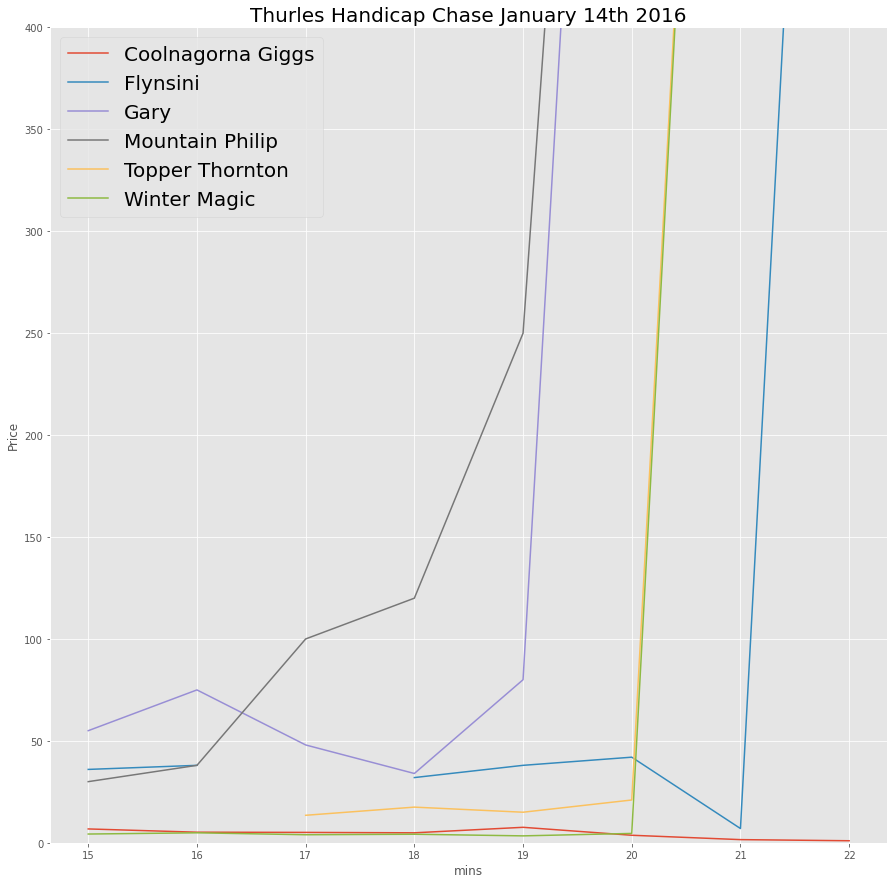

In [352]:
dfg = crc1.pivot(index='mins', columns='runner_name', values='last_traded_price')



ax = dfg.plot(xticks=dfg.index, ylabel='Price', ylim =(0, 400))
plt.rcParams["figure.figsize"] = [15, 15]
plt.legend(loc=2, prop={'size': 20})
plt.title("Thurles Handicap Chase January 14th 2016", size = 20)


In [ ]:
# https://stackoverflow.com/questions/44893565/get-list-of-mysql-databases-with-python
cursor = mydb.cursor()
databases = ("show databases")
cursor.execute(databases)
for (databases) in cursor:
     print (databases[0])

In [ ]:
#https://www.geeksforgeeks.org/how-to-show-all-tables-in-mysql-using-python/
mycursor = mydb.cursor()
mycursor.execute("Show tables;")
myresult = mycursor.fetchall()
 
for x in myresult:
    print(x)